In [1]:
import warnings
warnings.filterwarnings('ignore')

### First ML : Linear Regression

In [57]:
%%time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os

imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))


images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
    images_base_vide+=[im]
    label_nom_vide+=[file.split('/')[2].split('_')[0]]   ## Attention ici Solène si ça marche pas . Pas meme code pour chemin ...

images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), k*90, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('/')[2].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('/')[2].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

CPU times: user 13.5 s, sys: 2.54 s, total: 16.1 s
Wall time: 16.7 s
Parser   : 253 ms


## Linear Regression - Classique / Label num 

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [106]:
regr = linear_model.LinearRegression()
# X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

regr.fit(Train_Classique['data'], Train_Classique['label_num']) # Train the model using Train Classique 
Y_predict_classique = regr.predict(Test_Classique['data'])

In [107]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Test_Classique['label_num'], Y_predict_classique))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Test_Classique['label_num'], Y_predict_classique))



Coefficients: 
 [ 1.64404273e+09  5.76214936e+08 -1.00929518e+09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Mean squared error: 560489784767809828421632.00
Variance score: -463385262676931273293824.00


In [146]:
Test_Classique['data'].shape


(303, 4096)

In [122]:
Test_Classique['label_num'].shape

(303,)

ValueError: x and y must be the same size

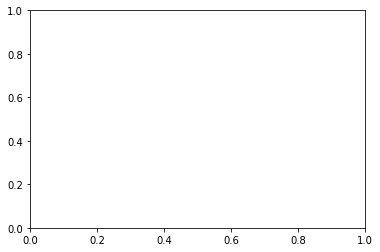

In [135]:
# Plot outputs
plt.scatter(Test_Classique['data'], Test_Classique['label_num'], color='black')
plt.plot(Test_Classique['data'], Y_predict_classique, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [152]:
from sklearn import metrics
print(metrics.classification_report(Y_predict_classique, Test_Classique['label_num']))

ValueError: Mix type of y not allowed, got types {'multiclass', 'continuous'}

In [ ]:
# + Matrice de confusion

## Random Forest

In [154]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns; sns.set()


In [155]:
from sklearn.cross_validation import train_test_split

model = RandomForestClassifier()
model.fit(Train_Classique['data'],Train_Classique['label_num'])
ypred_classique = model.predict(Test_Classique['data'])

In [156]:
from sklearn import metrics
print(metrics.classification_report(ypred_classique, Test_Classique['label_num']))

             precision    recall  f1-score   support

          0       0.67      0.52      0.59        86
          1       0.30      0.39      0.34        59
          2       0.53      0.45      0.49        93
          3       0.43      0.52      0.47        65

avg / total       0.50      0.48      0.48       303



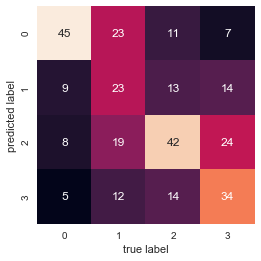

In [157]:
# Matrice de confusion pour analyse des résultats 

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Test_Classique['label_num'], ypred_classique)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');